Episodes: 100%|██████████| 1000/1000 [00:10<00:00, 91.09it/s]


Episodes logged: 1000
Steps per episode: mean = 317.59, min = 26, max = 2702
Reward per episode: mean = -316.59, min = -2701.00, max = -25.00


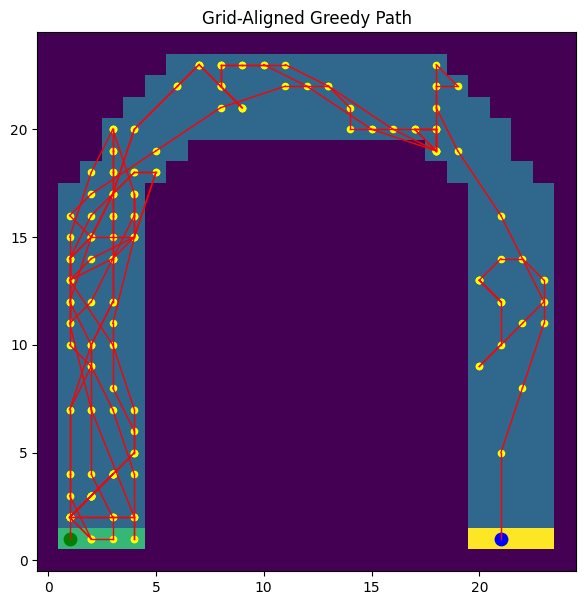

In [ ]:
from typing import List,Tuple,TypeAlias,Set, Dict
from enum import Enum, auto
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math

# Parameters: This line is a must. The grader parser uses this line to locate the Parameters cell.
GROUP_ID = 29
ALGORITHM = 'QLrng'  # ValItr | QLrng | SARSA. Note that “|” denotes a choice. Only one of the choices should be provided.
TRACK_NAME = 'tracks/U-track.txt'
CRASH_POS = 'STRT' # NRST | STRT


FAIL_RATE = 0.2
START_IDX = 0
CRASH_SENSISTIVITY = 0.75

# region Definitions and Setup
Square: TypeAlias = Tuple[int, int]
Vector: TypeAlias = Tuple[int, int]

class SquareType(Enum):
    START = auto()       # starting square ('S')
    FINISH = auto()      # finish square ('F')
    OPEN = auto()        # open path ('.')
    WALL = auto()        # wall ('#')
    
    def __str__(self):
        return self.name

CHAR_TO_TOK = {
    'S':SquareType.START,
    'F':SquareType.FINISH,
    '.':SquareType.OPEN,
    '#':SquareType.WALL
}

TOK_TO_CHAR = {k:v for v,k in CHAR_TO_TOK.items()}

SQUARE_COST = {
    SquareType.START: 1,
    SquareType.OPEN: 1,
    SquareType.FINISH: 0,
    SquareType.WALL: None
}

def bresenham_supercover(pos1: Square, pos2: Square) -> List[Square]:
    """
        Classic 1-pixel-wide supercover Bresenham.
    """
    x0, y0 = pos1
    x1, y1 = pos2

    dx = x1 - x0
    dy = y1 - y0

    sx = 1 if dx >= 0 else -1
    sy = 1 if dy >= 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    x, y = x0, y0
    points: List[Square] = [(x, y)]

    if dx == 0 and dy == 0:
        return points

    if dx >= dy:
        err = dx // 2
        while x != x1:
            err -= dy
            if err < 0:
                y += sy
                points.append((x, y))
                err += dx
            x += sx
            points.append((x, y))
    else:
        err = dy // 2
        while y != y1:
            err -= dx
            if err < 0:
                x += sx
                points.append((x, y))
                err += dy
            y += sy
            points.append((x, y))

    return points

def point_segment_distance(px, py, x1, y1, x2, y2):
    """
    Euclidean distance from point P to segment AB.
    Uses projection and clamping.
    """
    # Vector from A to P
    APx = px - x1
    APy = py - y1

    # Vector A->B
    ABx = x2 - x1
    ABy = y2 - y1

    # Project AP onto AB, normalized by |AB|^2
    mag2 = ABx * ABx + ABy * ABy
    if mag2 == 0:
        # A and B are the same point
        return math.hypot(APx, APy)

    t = (APx * ABx + APy * ABy) / mag2
    t = max(0.0, min(1.0, t))  # clamp

    # Closest point on segment
    cx = x1 + t * ABx
    cy = y1 + t * ABy

    return math.hypot(px - cx, py - cy)

def bresenham_line(pos1: Square, pos2: Square, width: float = CRASH_SENSISTIVITY) -> List[Square]:
    """
    Floating-width thick Bresenham line.
    Returns unique grid squares touched by the thickened line.
    """
    if width < 0:
        raise ValueError("width must be >= 0")

    center_line = bresenham_supercover(pos1, pos2)

    # If thin line requested
    if width == 0.0:
        return center_line

    out: Set[Square] = set()

    # Convert endpoints to center coordinates
    x1, y1 = pos1[0] + 0.5, pos1[1] + 0.5
    x2, y2 = pos2[0] + 0.5, pos2[1] + 0.5

    # Determine bounding box of candidate squares
    min_x = min(p[0] for p in center_line) - math.ceil(width)
    max_x = max(p[0] for p in center_line) + math.ceil(width)
    min_y = min(p[1] for p in center_line) - math.ceil(width)
    max_y = max(p[1] for p in center_line) + math.ceil(width)

    # Check all cells within bounding rectangle
    for x in range(min_x, max_x + 1):
        for y in range(min_y, max_y + 1):
            # center of this grid cell
            cx = x + 0.5
            cy = y + 0.5
            d = point_segment_distance(cx, cy, x1, y1, x2, y2)

            if d <= width:
                out.add((x, y))

    return list(out)
# endregion

# region Track and Environment Classes
class Track:
    def __init__(self,filename=TRACK_NAME):
        self.state: List[List[SquareType]] = []
        self.start_squares: List[Square] = []
        self.finish_squares: List[Square] = []

        self.parse_track(filename)

    def __str__(self):
        out = ""
        for row in self.state:
            out += ''.join([TOK_TO_CHAR[tok] for tok in row])
            out += '\n'
        return out[:-1]

    def parse_track(self,track):
        with open(track, 'r') as f:
            lines = f.readlines()
            for row,line in enumerate(lines[1:]):
                tok_line = []
                for col,char in enumerate(line):
                    if char=='\n': continue
                    
                    tok = CHAR_TO_TOK[char]
                    if tok == SquareType.START: self.start_squares.append((row,col))
                    if tok == SquareType.FINISH: self.finish_squares.append((row,col))
                    
                    tok_line.append(tok)
                
                self.state.append(tok_line)

    def get_square(self,square: Square) -> SquareType:
        return self.state[square[0]][square[1]]

    def get_drivable_squares(self) -> List[Square]:
        """
        Returns all squares that are not walls
        """
        return [
            (r, c)
            for r, row in enumerate(self.state)
            for c, col in enumerate(row)
            if col != SquareType.WALL
        ]

    def get_start_squares(self) -> List[Square]:
        return self.start_squares

    def is_square_finish(self, square: Square) -> bool:
        return self.get_square(square) == SquareType.FINISH


    def is_square_drivable(self,square: Square) -> bool:
        r, c = square
        if r < 0 or r >= len(self.state):
            return False
        if c < 0 or c >= len(self.state[0]):
            return False
        return self.get_square(square) != SquareType.WALL

class RaceTrackEnv:
    def __init__(self, track: None|Track = None,starting_square: Square = None):
        self.track:        Track = track or Track()
        self.position:     Square = starting_square or self.track.start_squares[START_IDX]
        self.velocity:     Vector = (0,0)
        self.acceleration: Vector = (0,0)

    def stop(self):
        self.acceleration = self.velocity = (0,0)

    def reset(self, position: Square):
        self.stop()
        self.position = position

    @staticmethod
    def cap_velocity(velocity: Vector) -> Vector:
        return tuple(min(5,max(-5,val)) for val in velocity)


    def do_crash(self,position: Square,crash_position: str):
        """
        Handles the crash based on the crash_position policy.
        crash_position: 'NRST' | 'STRT'
        1. 'NRST': Move to the nearest square.
        2. 'STRT': Move to the starting square used at the beginning of the race
        """
        if crash_position == 'NRST':
            nearest_start = min(self.track.get_drivable_squares(), key=lambda sq: (sq[0]-position[0])**2 + (sq[1]-position[1])**2)
            self.reset(nearest_start)
        elif crash_position == 'STRT':
            self.reset(self.track.start_squares[START_IDX])
        else:
            raise ValueError(f"Invalid crash_position policy: {crash_position}")

    def check_crash(self,target_square: Square) -> Square|None:
        """
        Check if moving along a line from current position to target crashes into an obstacle.
        Uses Bresenham's line algorithm to trace the path.
        """

        # Get all points along the path
        path_points = bresenham_line(
            self.position, target_square
        )
        # Check each point for collision
        for sq in path_points:
            if not self.track.is_square_drivable(sq):
                return sq  # Crash detected
        return None  # No crash

    @staticmethod
    def check_failure(fail_rate: float) -> bool:
        """
        Returns True if the action fails based on the fail_rate.
        """
        if random.random() < fail_rate:
            return True
        return False
    
    def check_finish(self) -> bool:
        return self.track.is_square_finish(self.position)

    def step(self,acceleration: Vector,fail_rate=FAIL_RATE,crash_position=CRASH_POS):
        """
        Perform a step in the environment given an acceleration.
        `Note velocity values are capped to [-5,5]`
        acceleration: Tuple[int,int] where each value is in [-1,0,1]
        fail_rate: Probability of action failure.
        crash_position: 'NRST' | 'STRT' policy for handling crashes.
        Returns: None
        """
        if not all(a in [-1,0,1] for a in acceleration):
            raise ValueError(f"Invalid acceleration: {acceleration}")
        
        do_accel = True
        if self.check_failure(fail_rate): do_accel = False
        if do_accel:
            self.acceleration = acceleration
        
        self.velocity = self.cap_velocity((self.velocity[0]+self.acceleration[0],self.velocity[1]+self.acceleration[1]))
        target_position = (self.position[0]+self.velocity[0],self.position[1]+self.velocity[1])

        crash = self.check_crash(target_position)
        if not crash: self.position = target_position
        else: self.do_crash(crash,crash_position)


# endregion

# region Model Based
State: TypeAlias = Tuple[Square,Vector]

class MDPModel:
    """
    For use with ValueIterationAgent
    """
    def __init__(self, track: Track|None = None):
        # List / iterable of all states in the MDP
        self.track = track or Track()
        self.states: Set[State] = set([
            (square, (vx, vy))
            for square in self.track.get_drivable_squares()
            for vx in range(-5, 6)
            for vy in range(-5, 6)
        ])
        self.crash_cache: Dict[(Square,Square):Square] = {}
        self.transitions: Dict[(State, Vector):List[(State, float)]] = {
            (state,action):self.compute_transition_states_and_probs(state,action)
            for state in tqdm(self.states,desc="Computing Transitions")
            for action in self.get_possible_actions()
        }

        

    @staticmethod
    def cap_velocity(velocity: Vector) -> Vector:
        return tuple(min(5,max(-5,val)) for val in velocity)
    


    def check_crash(self, start_square: Square, target_square: Square) -> Square | None:
        """
        Check if moving along a line from start_square to target_square crashes into an obstacle.
        Uses Bresenham's line algorithm to trace the path.
        Returns the first crash square, or None if no crash.
        """
        path = (start_square, target_square)
        if path in self.crash_cache:
            return self.crash_cache[path]

        path_points = bresenham_line(start_square, target_square)

        crash_square = None
        for sq in path_points:
            if crash_square is not None: break
            crash_square = crash_square if self.track.is_square_drivable(sq) else sq


        self.crash_cache[path] = crash_square
        return crash_square

    def do_crash(self, position: Square,crash_position: str):
        if crash_position == 'NRST':
            nearest_start = min(self.track.get_drivable_squares(), key=lambda sq: (sq[0]-position[0])**2 + (sq[1]-position[1])**2)
            return nearest_start
        elif crash_position == 'STRT':
            return self.track.start_squares[START_IDX]
        else:
            raise ValueError(f"Invalid crash_position policy: {crash_position}")

    @staticmethod
    def get_possible_actions() -> List[Vector]:
        """
        Actions are accelerations in this problem.
        :return: a list of possible actions (acceleration values).
        """
        return [(x,y) for x in [-1,0,1] for y in [-1,0,1]]

    def compute_transition_states_and_probs(self, state: State, action,crash_position=CRASH_POS) -> List[Tuple[State, float]]:
        """
        Return a list of (next_state, prob) pairs describing the transition
        model P(s' | s, a).
        """
        start_position,start_velocity = state

        success_velocity = self.cap_velocity((start_velocity[0]+action[0],start_velocity[1]+action[1]))
        success_position = (start_position[0]+success_velocity[0],start_position[1]+success_velocity[1])
        crash = self.check_crash(start_position, success_position)
        if crash:
            success_position = self.do_crash(crash,crash_position)
            success_velocity = (0,0)

        fail_velocity = self.cap_velocity(start_velocity)
        fail_position = (
            start_position[0] + fail_velocity[0],
            start_position[1] + fail_velocity[1],
        )
        crash = self.check_crash(start_position, fail_position)
        if crash:
            fail_position = self.do_crash(crash, crash_position)
            fail_velocity = (0, 0)


        return ([
            ((fail_position,fail_velocity),FAIL_RATE),
            ((success_position,success_velocity),1-FAIL_RATE)
        ])

    def get_transition_states_and_probs(self,state:State, action:Vector):
        return self.transitions[(state,action)]

    def get_cost(self, next_state):
        """
        Return the immediate cost
        """
        return SQUARE_COST[self.track.get_square(next_state[0])]


class ValueIterationAgent:
    """
    Classic value-iteration planner:
    After convergence we extract a greedy policy.
    """
    def __init__(self, model: MDPModel | None = None,
                 gamma: float = 0.9,
                 theta: float = 1e-3):
        # Value function: dict[state] -> float
        self.value_table: dict = {}
        # Deterministic greedy policy: dict[state] -> action
        self.policy: dict = {}

        self.model: MDPModel | None = model
        self.gamma: float = gamma
        self.theta: float = theta  # convergence threshold

        # If a model is already provided and has states, initialize and run VI
        if self.model is not None and hasattr(self.model, "states"):
            for s in self.model.states:
                self.value_table[s] = 0.0
            self.value_iteration()

    def value_iteration(self, max_iterations: int = 1000):
        assert self.model is not None

        # Ensure all states are in the value table
        for s in self.model.states:
            self.value_table.setdefault(s, 0.0)

        delta0 = None  # initial delta

        for i in range(1, max_iterations + 1):
            delta = 0.0

            # ----- one sweep -----
            for s in self.model.states:
                pos, vel = s

                if self.model.track.is_square_finish(pos):
                    new_v = 0.0
                else:
                    actions = self.model.get_possible_actions()
                    if not actions:
                        new_v = 0.0
                    else:
                        best_q = float("-inf")
                        for a in actions:
                            q = 0.0
                            for next_state, prob in self.model.get_transition_states_and_probs(s, a):
                                assert self.model.get_cost(next_state) is not None, f"ValueIterationAgent: encountered invalid cost for next state {next_state}."
                                r = -self.model.get_cost(next_state)
                                q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
                            if q > best_q:
                                best_q = q
                        new_v = best_q

                delta = max(delta, abs(new_v - self.value_table.get(s, 0.0)))
                self.value_table[s] = new_v

            if delta0 is None:
                delta0 = max(delta, 1e-12)  # avoid divide-by-zero

            if delta0 <= self.theta:
                progress = 1.0
            else:
                progress = 1.0 - (delta - self.theta) / (delta0 - self.theta)
                progress = max(0.0, min(1.0, progress))

            print(f"Iter {i} | Delta = {delta:.6f} | Progress: {progress*100:.2f}%")

            if delta < self.theta:
                break

        self._extract_policy()



    def _extract_policy(self):
        assert self.model is not None, "ValueIterationAgent: model is not set."

        self.policy.clear()
        for s in self.model.states:
            pos, vel = s
            if self.model.track.is_square_finish(pos):
                continue  # terminal, no action

            actions = self.model.get_possible_actions()
            if not actions:
                continue

            best_a = None
            best_q = float("-inf")
            for a in actions:
                q = 0.0
                for next_state, prob in self.model.get_transition_states_and_probs(s, a):
                    r = -self.model.get_cost(next_state)
                    q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
                if q > best_q:
                    best_q = q
                    best_a = a

            self.policy[s] = best_a


    def get_action_for(self, state):
        """
        Return the greedy action for `state` according to the current policy.
        If the state is unknown, fall back to a simple default (None).
        """
        if state in self.policy:
            return self.policy[state]

        if self.model is None:
            return None

        actions = self.model.get_possible_actions()
        if not actions:
            return None

        best_a = None
        best_q = float("-inf")
        for a in actions:
            q = 0.0
            for next_state, prob in self.model.get_transition_states_and_probs(state, a):
                r = -self.model.get_cost(next_state)
                q += prob * (r + self.gamma * self.value_table.get(next_state, 0.0))
            if q > best_q:
                best_q = q
                best_a = a

        return best_a

    def extract_greedy_path(self, max_steps: int = 1000) -> List[Square]:
        """
        Roll out the greedy policy from the first start square.
        Returns a list of positions (Squares).
        """

        start_square = self.model.track.start_squares[START_IDX]
        state: State = (start_square, (0, 0))

        path: List[Square] = [start_square]

        for t in range(max_steps):
            pos, vel = state

            # Stop if finish
            if self.model.track.is_square_finish(pos):
                break

            action = self.get_action_for(state)

            # Deterministic greedy next state
            transitions = self.model.get_transition_states_and_probs(state, action)
            next_state, _ = max(transitions, key=lambda item: item[1])

            state = next_state
            path.append(state[0])

        return path


    def stochastic_greedy_path(self, max_steps: int = 1000) -> List[Square]:
        """
        Roll out the greedy policy from start_square
        """

        start_square = self.model.track.start_squares[START_IDX]
        state: State = (start_square, (0, 0))

        path: List[Square] = [start_square]

        for t in range(max_steps):
            pos, vel = state

            # Stop if finish
            if self.model.track.is_square_finish(pos):
                break


            action = self.get_action_for(state)
            transitions = self.model.get_transition_states_and_probs(state, action)
            next_state,_ = transitions[0] if random.random() < transitions[0][1] else transitions[1]

            state = next_state
            path.append(state[0]) 
        return path
# endregion


# region Model Free
class SARSAAgent:
    def __init__(self):
        qtable = {}
        alpha = 0
        gamma = 0
        epsilon = 0
        last_state = None
        last_action = None

    def act(self,state):
        pass

    def update(self,state,action,reward,next_state,next_action):
        pass

    def best_action(self,state):
        pass

class QLearningAgent:
    def __init__(
        self,
        alpha: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 1.0,      # start fully random
        epsilon_min: float = 0.05, # do not decay below this
        epsilon_decay: float = 0.995,  # multiply each episode
    ):
        self.qtable = {}
        self.alpha = alpha
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.actions = MDPModel.get_possible_actions()

    def decay_epsilon(self):
        """Call this once per episode."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


    def _q_value(self, state: State, action: Vector) -> float:
        return self.qtable.get((state, action), 0.0)

    def best_action(self, state: State) -> Vector:
        """
        Greedy action wrt current Q-values.
        If all Q are equal / zero, just pick randomly.
        """
        if not self.actions:
            return (0, 0)

        best_a = None
        best_q = float("-inf")
        candidates: List[Vector] = []

        for a in self.actions:
            q = self._q_value(state, a)
            if q > best_q:
                best_q = q
                candidates = [a]
            elif q == best_q:
                candidates.append(a)

        # tie-break randomly among best
        best_a = random.choice(candidates)
        return best_a

    def act(self, state: State) -> Vector:
        """
        ε-greedy action selection.
        """
        if not self.actions:
            return (0, 0)

        if random.random() < self.epsilon:
            return random.choice(self.actions)
        else:
            return self.best_action(state)

    def update(
        self,
        state: State,
        action: Vector,
        reward: float,
        next_state: State | None,
        done: bool = False,
    ):
        """
        Q-learning update:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s', a') - Q(s,a) ]
        If done=True, the max term is 0.
        """
        sa = (state, action)
        old_q = self.qtable.get(sa, 0.0)

        if done or next_state is None:
            target = reward
        else:
            # max_a' Q(s', a')
            max_next_q = max(
                self._q_value(next_state, a) for a in self.actions
            )
            target = reward + self.gamma * max_next_q

        new_q = old_q + self.alpha * (target - old_q)
        self.qtable[sa] = new_q

# endregion

# region Output and Metrics
class EpisodeRunner:
    def __init__(self, env: RaceTrackEnv, agent: QLearningAgent | SARSAAgent,
                 max_steps: int = 1000):
        self.env = env
        self.agent = agent
        self.max_steps = max_steps

    def _current_state(self) -> State:
        return (self.env.position, self.env.velocity)

    def _reward(self) -> float:
        """
        Use the same convention as value iteration:
        reward = -cost(square), i.e. -1 per step, 0 on finish.
        """
        square_type = self.env.track.get_square(self.env.position)
        cost = SQUARE_COST[square_type]
        # cost is 1 on open/start, 0 on finish
        return -float(cost)

    def run_episode(self, start_square: Square | None = None) -> Tuple[int, float]:
        """
        Run one episode of interaction with the environment using the given agent.
        Returns: (steps, total_reward)
        """

        # Reset env to a start square
        if start_square is None:
            start_square = self.env.track.start_squares[START_IDX]
        self.env.reset(start_square)

        total_reward = 0.0
        steps = 0

        for t in range(self.max_steps):
            state: State = self._current_state()

            # choose action
            action = self.agent.act(state)

            # environment transition
            self.env.step(action)

            # observe reward and next state
            reward = self._reward()
            total_reward += reward
            steps += 1

            next_state: State = self._current_state()
            done = self.env.track.is_square_finish(self.env.position)

            # Q-learning update
            self.agent.update(state, action, reward, None if done else next_state, done=done)

            if done:
                break

        return steps, total_reward




class MetricsLogger:
    def __init__(self):
        self.episodes: List[int] = []
        self.steps: List[int] = []
        self.rewards: List[float] = []

    def log_episode(self, episode: int, steps: int, reward: float):
        """
        Store metrics for a single episode.
        """
        self.episodes.append(episode)
        self.steps.append(steps)
        self.rewards.append(reward)

    def print_metrics(self):
        """
        Print simple summary statistics over episodes.
        """
        if not self.episodes:
            print("No episodes logged.")
            return

        n = len(self.episodes)
        avg_steps = sum(self.steps) / n
        avg_reward = sum(self.rewards) / n

        print(f"Episodes logged: {n}")
        print(f"Steps per episode: mean = {avg_steps:.2f}, "
              f"min = {min(self.steps)}, max = {max(self.steps)}")
        print(f"Reward per episode: mean = {avg_reward:.2f}, "
              f"min = {min(self.rewards):.2f}, max = {max(self.rewards):.2f}")

    def plot_path(self, track: Track, path: List[Square]):
        import matplotlib.pyplot as plt
        import numpy as np

        n_rows = len(track.state)
        n_cols = len(track.state[0])

        # Build grid image
        grid = np.zeros((n_rows, n_cols))
        for r, row in enumerate(track.state):
            for c, cell in enumerate(row):
                if cell == SquareType.WALL:
                    grid[r, c] = 0
                elif cell == SquareType.OPEN:
                    grid[r, c] = 1
                elif cell == SquareType.START:
                    grid[r, c] = 2
                elif cell == SquareType.FINISH:
                    grid[r, c] = 3

        plt.figure(figsize=(7, 7))
        plt.imshow(grid, origin="upper")

        # Draw each step separately to avoid diagonal corner-cutting visuals
        for (r1, c1), (r2, c2) in zip(path[:-1], path[1:]):
            plt.plot([c1, c2], [r1, r2], color="red", linewidth=1)

        # Mark start and end
        (sr, sc) = path[0]
        (er, ec) = path[-1]
        for (r, c) in path:
            plt.scatter([c], [r], s=20, color="yellow")
        plt.scatter([sc], [sr], s=80, color="green")   # start
        plt.scatter([ec], [er], s=80, color="blue")    # end

        plt.gca().invert_yaxis()
        plt.title("Grid-Aligned Greedy Path")
        plt.savefig(f"{GROUP_ID}_{ALGORITHM}_{TRACK_NAME.split('/')[-1]}_{CRASH_POS}.png")
        plt.show()


# endregion

def main():
    track = Track(TRACK_NAME)

    if ALGORITHM == 'ValItr':
        model = MDPModel(track)
        agent = ValueIterationAgent(model=model, gamma=0.9, theta=1e-3)

        logger = MetricsLogger()
        best_path = agent.extract_greedy_path()
        print("Path: ", best_path)
        logger.plot_path(track, best_path)

    elif ALGORITHM == 'QLrng':
        # Q-learning
        env = RaceTrackEnv(track)
        agent = QLearningAgent(alpha=0.1, gamma=0.95, epsilon=0.1)
        runner = EpisodeRunner(env, agent, max_steps=10_000)
        logger = MetricsLogger()

        n_episodes = 1_000 
        for ep in tqdm(range(1, n_episodes + 1),desc="Episodes"):
            steps, total_reward = runner.run_episode()

            agent.decay_epsilon()
            logger.log_episode(ep, steps, total_reward)

        logger.print_metrics()

        # Extract a greedy path from the learned Q-policy
        path: List[Square] = []
        env.reset(track.start_squares[START_IDX])
        for t in range(1000):
            pos = env.position
            path.append(pos)
            if track.is_square_finish(pos):
                break
            state: State = (env.position, env.velocity)
            action = agent.best_action(state)
            env.step(action)

        logger.plot_path(track, path)

    else:
        raise ValueError(f"Unknown ALGORITHM: {ALGORITHM}")



if __name__ == "__main__":
    main()




